# ARIMA Modeling Review

## Generate Sample Data

In [133]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

Generate sample data from ARMA(2, 2) model. 

In [147]:
#length of generated time series
T = 200

#generate random sample of ARMA(2,2)
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
X = sm.tsa.arma_generate_sample(ar, ma, T)
model = sm.tsa.ARMA(X, (2, 2)).fit(trend='nc', disp=0)
model.params

array([ 0.82055658, -0.24872198,  0.66982857,  0.38120519])

Add linear trend.

In [151]:
X = X + .05*np.array(range(T))

In [152]:
df_X = pd.DataFrame(X)

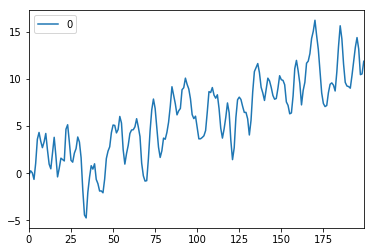

In [153]:
df_X.plot()

## Evaluate Initial Baseline Model

### Train-Test Split

In [177]:
train_size = 160
X_train, X_test = X[0:train_size], X[train_size:len(X)]

### Difference Series for Stationarity

In [178]:
from statsmodels.tsa.arima_model import ARIMA

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

#for later - to invert differencing after ARMA prediction on stationary series
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

### Fit Baseline Model to Training Data

Start with AR(1) = ARIMA(1,0,0)

In [179]:
X_differenced = difference(X)
X_train_differenced = difference(X_train)
# fit model
model = ARIMA(X_train_differenced, order=(1,0,0))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.params)

[0.08330888 0.48180995]


Check that fitting ARIMA of d one higher order - ARIMA(1,1,0) - on undifferenced series gives same result:

In [182]:
model2 = ARIMA(X_train, order=(1,1,0))
model2_fit = model.fit(disp=0)
print(model2_fit.params)

[0.08330888 0.48180995]


statsmodels does the differencing for us!

### Plot ACF and PACF

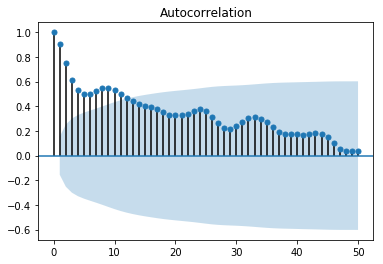

In [180]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(X_train, lags=50);

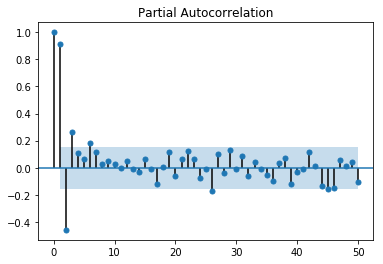

In [181]:
plot_pacf(X_train, lags=50);

### Evaluate Fitted Model on Test Data

Combine train-test split, fitting, and evaluation on test set into one function. 

In [159]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order, train_frac):
    # prepare training dataset
    train_size = int(len(X) * train_frac)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [164]:
arima_order = (1,1,0)
train_frac = .8
X = X_train

rmse_test = evaluate_arima_model(X, arima_order, train_frac)
print("RMSE on test set: " + str(rmse_test))

predicted=12.421851, expected=10.862061
predicted=10.373329, expected=9.528470
predicted=8.915620, expected=7.239483
predicted=6.138708, expected=8.781229
predicted=9.537958, expected=9.633068
predicted=10.067647, expected=11.653680
predicted=12.653727, expected=11.880605
predicted=12.027049, expected=12.681617
predicted=13.100895, expected=14.275952
predicted=15.077906, expected=15.046088
predicted=15.459449, expected=16.212694
predicted=16.818950, expected=14.570878
predicted=13.850071, expected=13.114375
predicted=12.469336, expected=10.764330
predicted=9.670798, expected=8.505707
predicted=7.429219, expected=7.389508
predicted=6.867316, expected=7.060705
predicted=6.922500, expected=7.172097
predicted=7.248905, expected=8.537080
predicted=9.229483, expected=9.426243
predicted=9.889464, expected=9.572688
predicted=9.673042, expected=9.331237
predicted=9.241479, expected=8.712872
predicted=8.437022, expected=10.729267
predicted=11.736612, expected=13.430068
predicted=14.801549, expec

## Grid Search p, d, q Parameters

Confirm that ARIMA(2,1,2) gives the best performance on the test data.

In [169]:
import warnings

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values, train_frac):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order, train_frac)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


# evaluate parameters
p_values = range(0, 3)
d_values = [0, 1] 
q_values = range(0, 3)
train_frac = .8
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values, train_frac)


predicted=4.691721, expected=10.862061
predicted=4.730046, expected=9.528470
predicted=4.759666, expected=7.239483
predicted=4.774879, expected=8.781229
predicted=4.799308, expected=9.633068
predicted=4.828604, expected=11.653680
predicted=4.869719, expected=11.880605
predicted=4.911700, expected=12.681617
predicted=4.957949, expected=14.275952
predicted=5.013086, expected=15.046088
predicted=5.072103, expected=16.212694
predicted=5.137253, expected=14.570878
predicted=5.192100, expected=13.114374
predicted=5.237893, expected=10.764330
predicted=5.269654, expected=8.505707
predicted=5.288146, expected=7.389508
predicted=5.300085, expected=7.060705
predicted=5.310032, expected=7.172097
predicted=5.320493, expected=8.537080
predicted=5.338463, expected=9.426243
predicted=5.361173, expected=9.572688
predicted=5.384441, expected=9.331237
predicted=5.406127, expected=8.712873
predicted=5.424197, expected=10.729267
predicted=5.453028, expected=13.430068
predicted=5.496148, expected=15.625923

predicted=16.165855, expected=14.570878
predicted=12.937351, expected=13.114374
predicted=12.517702, expected=10.764330
predicted=9.330071, expected=8.505707
predicted=7.748722, expected=7.389508
predicted=6.975887, expected=7.060705
predicted=6.915821, expected=7.172097
predicted=7.109945, expected=8.537080
predicted=8.979160, expected=9.426243
predicted=9.267873, expected=9.572688
predicted=9.330444, expected=9.331237
predicted=8.951143, expected=8.712873
predicted=8.261305, expected=10.729267
predicted=11.557060, expected=13.430068
predicted=13.744727, expected=15.625923
predicted=15.842776, expected=14.231497
predicted=12.660806, expected=11.568596
predicted=10.454186, expected=9.624278
predicted=8.798092, expected=9.242270
predicted=9.142563, expected=9.179708
predicted=8.867524, expected=9.012113
predicted=8.775082, expected=10.347401
predicted=10.780110, expected=11.869642
predicted=11.926043, expected=13.338628
predicted=13.478839, expected=14.374732
predicted=14.180722, expect

predicted=9.269214, expected=9.331237
predicted=8.843624, expected=8.712873
predicted=8.078769, expected=10.729267
predicted=11.335210, expected=13.430068
predicted=14.224450, expected=15.625923
predicted=16.022212, expected=14.231497
predicted=12.738020, expected=11.568596
predicted=9.575439, expected=9.624278
predicted=8.198876, expected=9.242270
predicted=8.715698, expected=9.179708
predicted=8.834916, expected=9.012113
predicted=8.627104, expected=10.347401
predicted=10.668152, expected=11.869642
predicted=12.180782, expected=13.338628
predicted=13.522997, expected=14.374732
predicted=14.260569, expected=13.165046
predicted=11.901364, expected=10.446942
predicted=8.547275, expected=10.519517
predicted=10.173898, expected=11.863276
ARIMA(2, 0, 0) RMSE=1.292
predicted=11.303451, expected=10.862061
predicted=9.528826, expected=9.528470
predicted=8.448136, expected=7.239483
predicted=5.647646, expected=8.781229
predicted=9.915343, expected=9.633068
predicted=9.184918, expected=11.65368

predicted=9.970521, expected=9.624278
predicted=9.044288, expected=9.242270
predicted=9.714213, expected=9.179708
predicted=9.676580, expected=9.012113
predicted=9.472115, expected=10.347401
predicted=11.574026, expected=11.869642
predicted=12.656657, expected=13.338628
predicted=13.800061, expected=14.374732
predicted=14.326949, expected=13.165046
predicted=11.908349, expected=10.446942
predicted=9.094435, expected=10.519517
predicted=11.293322, expected=11.863276
ARIMA(2, 1, 2) RMSE=1.087
Best ARIMA(2, 1, 2) RMSE=1.087
